In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable


import rasterio
import rasterio.merge
import rasterio.mask
import geopandas as gpd
from osgeo import gdal, osr, ogr
from gdalconst import *
from shapely.geometry import box
import fiona
import richdem as rd

In [2]:
def get_tif_corners(tif_path):
    '''https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon'''
    ds=gdal.Open(tif_path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext=GetExtent(gt,cols,rows)

    src_srs=osr.SpatialReference()
    src_srs.ImportFromWkt(ds.GetProjection())
    #tgt_srs=osr.SpatialReference()
    #tgt_srs.ImportFromEPSG(4326)
    tgt_srs = src_srs.CloneGeogCS()
    geo_ext = np.array(ReprojectCoords(ext, src_srs, tgt_srs))
    return geo_ext


def load_tif_as_array(tiff_file):
    '''https://gis.stackexchange.com/questions/154669/editing-tiff-rasters-in-python/285685#285685'''
    geotransform = tiff_file.GetGeoTransform()
    projection = tiff_file.GetProjection()
    band = tiff_file.GetRasterBand(1)    
    xsize = band.XSize
    ysize = band.YSize
    array = band.ReadAsArray()
    tiff_file = None #close it
    band = None #close it
    return array


def GetExtent(gt,cols,rows):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print(x,y)
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    ''' Reproject a list of x,y coordinates.

        @type geom:     C{tuple/list}
        @param geom:    List of [[x,y],...[x,y]] coordinates
        @type src_srs:  C{osr.SpatialReference}
        @param src_srs: OSR SpatialReference object
        @type tgt_srs:  C{osr.SpatialReference}
        @param tgt_srs: OSR SpatialReference object
        @rtype:         C{tuple/list}
        @return:        List of transformed [[x,y],...[x,y]] coordinates
    '''
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

def get_tif_corners(path):
    ds=gdal.Open(path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext = np.array(GetExtent(gt,cols,rows))
# 
    # src_srs=osr.SpatialReference()
    # src_srs.ImportFromWkt(ds.GetProjection())
# 
    # tgt_srs = src_srs.CloneGeogCS()
# 
    # geo_ext=np.array(ReprojectCoords(ext, src_srs, tgt_srs))

    # X = lon/easting, Y = lat/northing
    x_min, x_max = np.min(ext[:, 0]), np.max(ext[:, 0])
    y_min, y_max = np.min(ext[:, 1]), np.max(ext[:, 1])
    
    return x_min, x_max, y_min, y_max

def merge_tifs(tif_path, write_path, **kwargs):
    '''Merges two tif files together using rasterio merge'''
    dataset1 = rasterio.open(tif_path[0])
    dataset2 = rasterio.open(tif_path[1])

    dest, output_transform = rasterio.merge.merge([dataset1,dataset2], **kwargs)

    with rasterio.open(ocean_mask_path) as src:
            out_meta = src.meta.copy()    
            out_meta.update({"driver": "GTiff",
                             "height": dest.shape[1],
                             "width": dest.shape[2],
                             "transform": output_transform})

    with rasterio.open(write_path, "w", **out_meta) as dest1:
            dest1.write(dest)
            
def get_bounds(bounds, padding=[0.01, 0.005, 0.01, 0.005]):
    '''Takes rasterio tif bounds as input. 
    Padding is a list of padding given in percentage of 
    bound size, and follows same order as bounds'''
    
    left_bound = bounds.left  - np.abs(bounds.left * padding[0])
    right_bound = bounds.right  + np.abs(bounds.right * padding[2])
    top_bound = bounds.top  + np.abs(bounds.top * padding[3])
    bottom_bound = bounds.bottom  - np.abs(bounds.bottom * padding[1])
    
    return left_bound, bottom_bound, right_bound, top_bound

def make_coordinate_arrays(raster_path):
    ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    gt = ds.GetGeoTransform()
    
    data = rasterio.open(raster_path)
    
    # build vector of coordinates from geotransform and array
    col = np.arange(0, data.read(1).shape[1])
    row = np.arange(0, data.read(1).shape[0])

    # col, row to x, y
    x = np.add(np.multiply(col, gt[1]), gt[0])
    y = np.add(np.multiply(row, gt[5]), gt[3])
    
    return x, y

def unit_test_bounds(raster_bounded, raster_bounds):
    '''Compare the raster which should be bounded by raster bounds by plotting the raster and the wanted bounds on top'''
    left_bound, bottom_bound, right_bound, top_bound = raster_bounds[:]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 9)
    plt.imshow(ocean_mask.read(1), 
               extent=[ocean_mask.bounds.left, 
                       ocean_mask.bounds.right, 
                       ocean_mask.bounds.bottom, 
                       ocean_mask.bounds.top], zorder=1)
    ax.scatter([left_bound, left_bound, right_bound, right_bound], [top_bound, bottom_bound, top_bound, bottom_bound], color='red', zorder=2, s=100)
    plt.show()
    
def crop_raster_to_bounds(raster_path, bounds):
    '''crop raster to bounds (l, b, r, t) tuple. Saves cropped raster in new file'''
    shape = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]})
    shape.to_file("tmp.shp")

    with fiona.open("tmp.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    new_name = raster_path.split(".")[0] + "_cropped.tif"

    with rasterio.open(new_name, "w", **out_meta) as dest:
        dest.write(out_image)
        
    os.remove("tmp.shp")
    os.remove("tmp.cpg")
    os.remove("tmp.dbf")
    os.remove("tmp.shx")
    return new_name

def dem_slope(dem, resolution=2):
    grads = np.gradient(dem, resolution)
    mag = np.hypot(grads[0], grads[1])
    return np.arctan(mag) * 180 / np.pi

def remove_nans(data, padding=2):
    while len(np.argwhere(np.isnan(data))) != 0:
        coord = np.argwhere(np.isnan(data))[0]
        pad = padding
        box = data[coord[0]-pad:coord[0]+pad, coord[1]-pad:coord[1]+pad]
        avg_box = np.nanmean(box)
        data[coord[0], coord[1]] = avg_box
    return data

### TASKS
- Make slope map, maybe gaussian blur all to get more robust zones. 
- Load RI
- Plot scatter point at geo coords based on slope, ri limit

## Paths

In [3]:
arcgis_tile_path = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/dem/DEM/karrat_fjord/dem/21_38_1_1_2m_v3.0_reg_dem.tif'
ri_path = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/t090a_v4_ri.tif'
coherence_stereo_path = "/Users/eyu/Google Drive/DTU/11_semester/master_thesis/preliminary_coding/first_simulations/coherence_stere.tif"

## LOAD DEM

In [4]:
arcgis_tile = rasterio.open(arcgis_tile_path)
ri = rasterio.open(ri_path)
coherence_stereo = rasterio.open(coherence_stereo_path)

In [5]:
row_start, row_stop = 15000, 20500
col_start, col_stop = 18000, -1
subset_dem = arcgis_tile.read(1)[row_start:row_stop, col_start:col_stop]

In [6]:
subset_dem = remove_nans(subset_dem, padding=1)

In [7]:
x, y = make_coordinate_arrays(arcgis_tile_path)
x, y = x[col_start:col_stop],  y[row_start:row_stop]

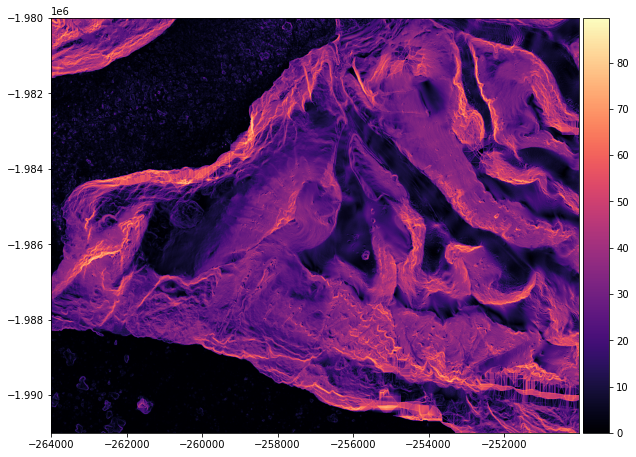

In [95]:
slope = dem_slope(subset_dem)
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(slope, extent=[x.min(), x.max(), y.min(), y.max()], cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

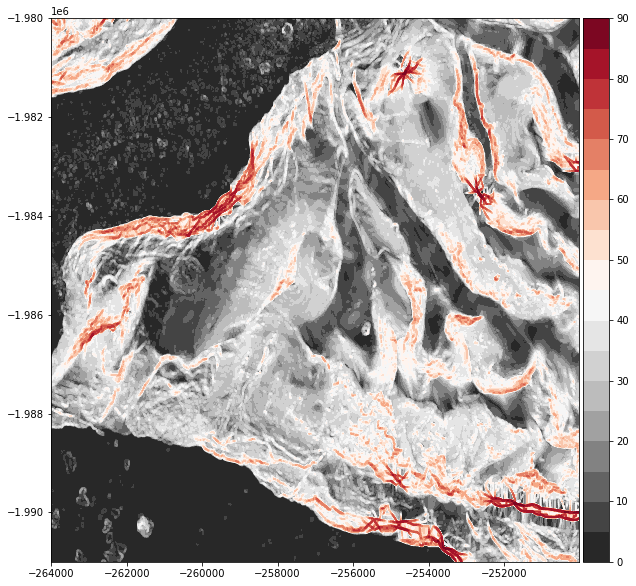

In [10]:
slope = dem_slope(gaussian_filter(subset_dem, sigma=5))
plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.contourf(x, y, slope, 20, cmap='RdGy_r') # ax.imshow(slope, extent=[x.min(), x.max(), y.min(), y.max()], cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [11]:
slope_zones = slope # gaussian_filter(slope, sigma=5)
slope_zones[slope_zones<15] = 0
slope_zones[slope_zones>15] = 1


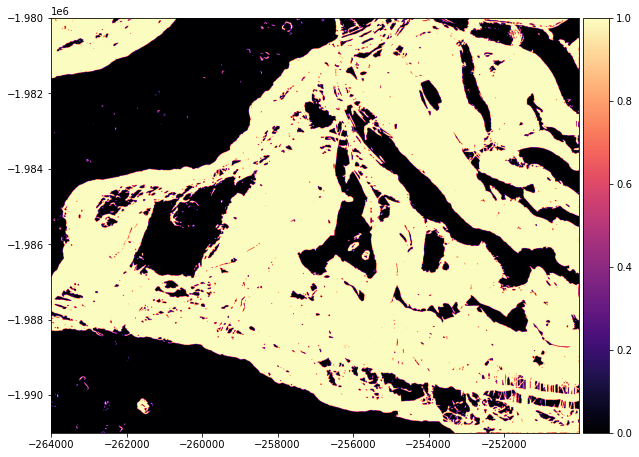

In [12]:
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(slope_zones, extent=[x.min(), x.max(), y.min(), y.max()], cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

### RI

In [57]:
ri_map = ri.read(1)

In [58]:
ri_map[np.where(np.isnan(ri_map))] = 0
ri_map[ri_map<0.5] = 0
ri_map[ri_map>0.5] = 1


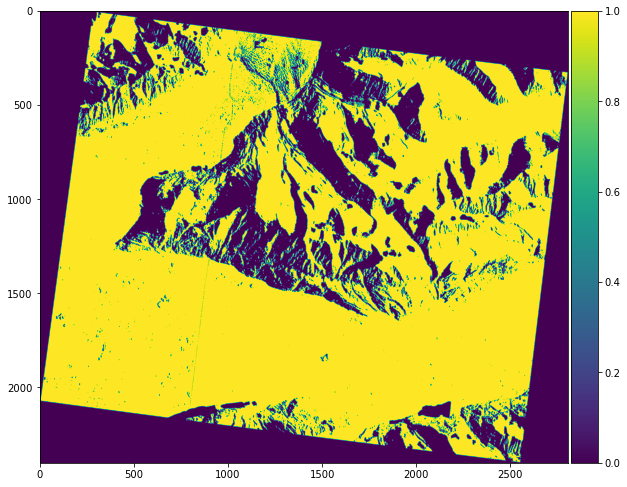

In [59]:
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(ri_map)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [52]:
ri_map = ri.read(1)

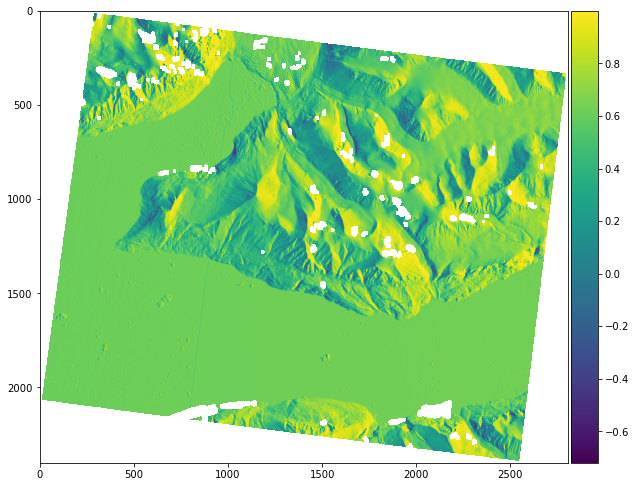

In [53]:
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(ri_map)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

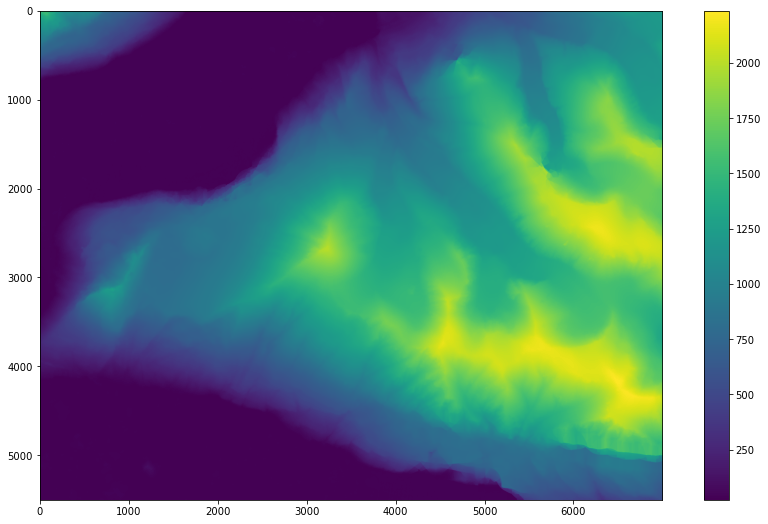

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
plt.imshow(subset_dem)
plt.colorbar()
plt.show()

In [35]:
test = subset_dem[2135:2155, 1765:1780]
test[16, 4]

330.589

In [25]:
dem = gdal.Open(arcgis_tile_path, GA_Update) 
dem_band = dem.GetRasterBand(1)

In [12]:
dst_filename = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/dem/DEM/karrat_fjord/dem/21_38_1_1_2m_v3.0_reg_dem_interpolated.tif'
dem = gdal.Open(arcgis_tile_path, GA_Update) 
dem_band = dem.GetRasterBand(1)
result = gdal.FillNodata(targetBand = dem_band, maskBand = None, maxSearchDist = 180, smoothingIterations = 1)
dem = None

In [ ]:
# dst_filename = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/dem/DEM/karrat_fjord/dem/21_38_1_1_2m_v3.0_reg_dem_interpolated.tif'
fileformat = "GTiff"
driver = gdal.GetDriverByName(fileformat)
dem = gdal.Open(arcgis_tile_path)
dem_interp = driver.CreateCopy(dst_filename, dem, strict=0)

dem_band = dem_interp.GetRasterBand(1)
result = gdal.FillNodata(targetBand = dem_band, maskBand = None, maxSearchDist = 250, smoothingIterations = 0)

dst_ds = None
src_ds = None

In [11]:
#first feature of the shapefile
first = shape.next()
print(first) # (GeoJSON format)


{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('objectid', 9227), ('name', '38_18_2_1_2m_v3.0'), ('tile', '38_18'), ('nd_value', -9999.0), ('resolution', 2.0), ('creationda', '2018-05-24'), ('raster', None), ('fileurl', 'http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/2m/38_18/38_18_2_1_2m_v3.0.tar.gz'), ('spec_type', 'DEM'), ('qual', 0.99947078), ('reg_src', 'ICESat'), ('num_gcps', 892), ('meanresz', -0.005), ('active', 1), ('qc', 2), ('rel_ver', '7'), ('num_comp', 48), ('st_area_sh', 2500000000.0), ('st_length_', 200000.0)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(-2250000.0, -250000.0), (-2200000.0, -250000.0), (-2200000.0, -300000.0), (-2250000.0, -300000.0), (-2250000.0, -250000.0)]]}}


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


In [33]:
shape.profile

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('objectid', 'int:10'),
               ('name', 'str:80'),
               ('tile', 'str:10'),
               ('nd_value', 'float:19.11'),
               ('resolution', 'float:19.11'),
               ('creationda', 'date'),
               ('raster', 'str:254'),
               ('fileurl', 'str:254'),
               ('spec_type', 'str:20'),
               ('qual', 'float:19.11'),
               ('reg_src', 'str:20'),
               ('num_gcps', 'int:5'),
               ('meanresz', 'float:19.11'),
               ('active', 'int:5'),
               ('qc', 'int:5'),
               ('rel_ver', 'str:10'),
               ('num_comp', 'int:5'),
               ('st_area_sh', 'float:19.11'),
               ('st_length_', 'float:19.11')]),
  'geometry': 'Polygon'},
 'crs': {'init': 'epsg:3413'},
 'crs_wkt': 'PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257

In [40]:
shape.schema['properties']

'str:80'